# Grad-TTS: A Diffusion Probabilistic Model for Text-to-Speech

Official implementation of the Grad-TTS model based on Diffusion Probabilistic Models. For all details check out our paper accepted to ICML 2021 via [this](https://arxiv.org/abs/2105.06337) link.

You can listen to the samples on our demo page via [this](https://grad-tts.github.io/) link.

You can access Google Colab demo notebook via [this](https://colab.research.google.com/drive/1YNrXtkJQKcYDmIYJeyX8s5eXxB4zgpZI?usp=sharing) link.

**Authors**: Vadim Popov\*, Ivan Vovk\*, Vladimir Gogoryan, Tasnima Sadekova, Mikhail Kudinov.

<sup>\*Equal contribution.</sup>

**Note**: for fast synthesis prefer running inference on GPU device.

In [26]:
%env CUDA_VISIBLE_DEVICES=7

env: CUDA_VISIBLE_DEVICES=7


In [27]:
import argparse
import json
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
from tqdm import tqdm
from scipy.io.wavfile import write

import torch

# For Grad-TTS
import params
from model import GradTTS
from text import text_to_sequence, cmudict
from text.symbols import symbols
from utils import intersperse

# For HiFi-GAN
import sys
sys.path.append('./hifi-gan/')
from env import AttrDict
from models import Generator as HiFiGAN
from utils import denormalize

In [28]:
import joblib as jl
from pathlib import Path
import warnings
from utils import generate_motion_visualization
motion_visualizer = jl.load("data/cormac/processed_sm0_0_86fps/data_pipe.expmap_86.1328125fps.sav")

/home/smehta/anaconda3/envs/gradtts/lib/python3.9/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator Pipeline from version 0.24.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [29]:
N_SPKS = 1  # 247 for Libri-TTS model and 1 for single speaker (LJSpeech)

In [83]:
# checkpoint_path = "logs/gradtts_rand_padFixedMirrorGPU3/grad_1024.pt"
checkpoint_path = "logs/FinalRunGPU2SingleNorm/grad_2512.pt"
# checkpoint_path = "logs/diffuser/grad_3646.pt"

In [84]:
# params.n_motions = 45 
# params.window_size=4
# params.encoder_type="default"

In [85]:
checkpoint = torch.load(checkpoint_path, map_location=lambda loc, storage: loc)
params = checkpoint['params']
params.encoder_type="default"
generator = GradTTS(len(symbols)+1, N_SPKS, params.spk_emb_dim,
                    params.n_enc_channels, params.filter_channels,
                    params.filter_channels_dp, params.n_heads, params.n_enc_layers,
                    params.enc_kernel, params.enc_dropout, params.window_size,
                    params.n_feats, params.n_motions, params.dec_dim, params.beta_min, params.beta_max,
                    1000, params.mu_motion_encoder_params, params.decoder_motion_type, params.motion_reduction_factor,only_speech=False,
                    encoder_type=params.encoder_type)  # pe_scale=1 for `grad-tts-old.pt`
generator.load_state_dict(checkpoint['model'])
# params = checkpoint['params']
_ = generator.cuda().eval()
print(f'Number of parameters: {generator.nparams}')

cmu = cmudict.CMUDict('./resources/cmu_dictionary')

Number of parameters: 80187727


In [86]:
with open('checkpts/hifigan-config.json') as f:
    h = AttrDict(json.load(f))
hifigan = HiFiGAN(h)
hifigan.load_state_dict(torch.load('checkpts/hifigan.pt', map_location=lambda loc, storage: loc)['generator'])
_ = hifigan.cuda().eval()
hifigan.remove_weight_norm()
%matplotlib inline

Removing weight norm...


In [87]:
text = "and the train stopped; The door opened; I got out first; Then Jack Kane got out, Ronan got out, Louise got out."
# text = "So, I went to the other side ; and then suddenly I saw someone running towards me, I didn't really understand who it was but then I heard the noise and I was like no, screw this ; I just started running and I ran as fast as I possibly could."
text = "on either side; and the ball gets put in he hooks it back in the scrum; , then they just start driving and I kind of forward and that sort of stuff So he's number two for me because he's so versatile, ; So strong."


In [88]:
x = torch.LongTensor(intersperse(text_to_sequence(text, dictionary=cmu), len(symbols))).cuda()[None]
x_lengths = torch.LongTensor([x.shape[-1]]).cuda()
x.shape, x_lengths

(torch.Size([1, 385]), tensor([385], device='cuda:0'))

Grad-TTS RTF: 3.599636227829392


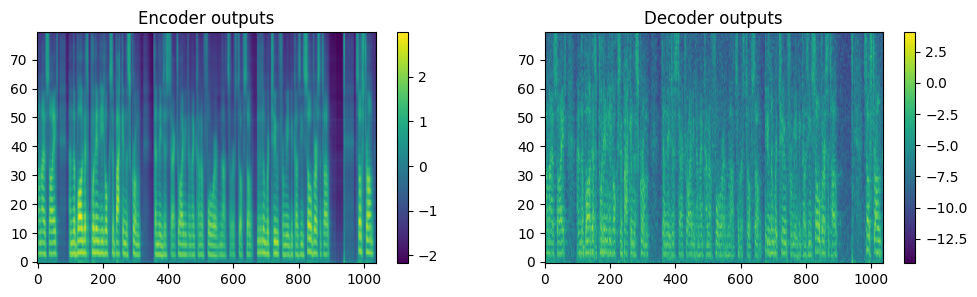

In [89]:
n_timesteps = {
    'mel': 1,
    'motion': 500,
}


t = dt.datetime.now()
generator.motion_reduction_factor = 1
y_enc, y_dec, y_motion_enc, y_motion_dec, attn = generator.forward(x, x_lengths, n_timesteps=n_timesteps, temperature=1.0,
                                       stoc=False, spk=None if N_SPKS==1 else torch.LongTensor([15]).cuda(),
                                       length_scale=1.0)
t = (dt.datetime.now() - t).total_seconds()
print(f'Grad-TTS RTF: {t * 22050 / (y_dec.shape[-1] * 256)}')
# Denormalize
y_dec = denormalize(y_dec, params.data_parameters['mel_mean'], params.data_parameters['mel_std'])
motion_output = denormalize(y_motion_dec[:, 3:], params.data_parameters['motion_mean'], params.data_parameters['motion_std'])
# motion_output = denormalize(y_motion_dec[:, :], params.data_parameters['motion_mean'], params.data_parameters['motion_std'])


plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1)
plt.title('Encoder outputs')
plt.imshow(y_enc.cpu().squeeze(), aspect='auto', origin='lower')
plt.colorbar()
plt.subplot(1, 2, 2)
plt.title('Decoder outputs')
plt.imshow(y_dec.cpu().squeeze(), aspect='auto', origin='lower')
plt.colorbar()

In [ ]:
plt.figure(figsize=(12, 3))
plt.imshow((motion_output + torch.randn_like(motion_output) * 0.2).cpu().squeeze(), aspect='auto', origin='lower')


In [19]:
# motion_output = denormalize(y_motion_dec[:, :], params.data_parameters['motion_mean'], params.data_parameters['motion_std'])
motion_output = denormalize(y_motion_dec[:, 3:], params.data_parameters['motion_mean'], params.data_parameters['motion_std'])

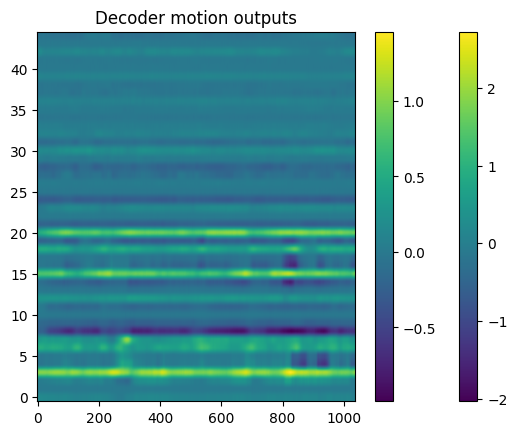

In [20]:
plt.title('Encoder motion outputs')
plt.imshow(y_motion_enc.cpu().squeeze(), aspect='auto', origin='lower')
plt.colorbar()
plt.title('Decoder motion outputs')
plt.imshow(motion_output.cpu().squeeze(), aspect='auto', origin='lower')
plt.colorbar()

In [21]:
y_dec.shape, y_motion_dec.shape

(torch.Size([1, 80, 1036]), torch.Size([1, 48, 1036]))

In [22]:
with torch.no_grad():
    audio = hifigan.forward(y_dec[:, :80]).cpu().squeeze().clamp(-1, 1)
ipd.display(ipd.Audio(audio, rate=22050))

In [23]:
# import torch.nn.functional as F

# motion_output = F.interpolate(motion_output[:, :, ::4], motion_output.shape[-1], mode='linear')
# # # motion_output = F.interpolate(motion_output[:, :, ::4], motion_output.shape[-1])
# # motion_output = motion_output[:, :, ::4]

In [24]:
# motion_visualizer20fps = jl.load("data/cormac/processed_sm0_0_20fps/data_pipe.expmap_20fps.sav")

In [25]:
output_folder = Path('syn_motion_output')
output_folder.mkdir(exist_ok=True, parents=True)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    i = 3
    # 86
    generate_motion_visualization(audio.cpu(), output_folder/f'{i}.wav', motion_output.cpu().squeeze(0).T, output_folder/f'{i}.mp4', motion_visualizer, output_folder/f'{i}.bvh')    
    # 20 fps
#     generate_motion_visualization(audio.cpu(), output_folder/f'{i}.wav', motion_output.cpu().squeeze(0).T, output_folder/f'{i}.mp4', motion_visualizer20fps, output_folder/f'{i}.bvh')    



MocapParameterizer: position


ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e